In [1]:
import logging
logging.basicConfig(
    level=logging.DEBUG, 
    format='%(levelname)-8s [%(lineno)d] %(message)s')

import gensim
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams['figure.dpi'] = 80

DEBUG    [73] Fast version of gensim.models.doc2vec is being used
INFO     [20] 'pattern' package not found; tag filters are not available for English


Populating the interactive namespace from numpy and matplotlib


In [72]:
df = pd.read_csv('dat/prevlex_verb_mx.tsv', sep='\t', index_col=0).T

## ppmi

In [114]:
def get_mx(df, wtype=False, log_smooth=1, divide_by_prev_freq=True, divide_by_verb_freq=False):
    mx = df
    if wtype:
        mx = np.sign(mx)
    margianl_verb = mx.sum(axis=0)
    margianl_prev = mx.sum(axis=1)
    if log_smooth:
        mx += log_smooth
        mx = np.log(mx)
        margianl_verb = np.log(margianl_verb)
        margianl_prev = np.log(margianl_prev)
    mx = mx.values
    if divide_by_verb_freq:
        if log_smooth:
            mx -= margianl_verb
        else:
            mx /= margianl_verb
    if divide_by_prev_freq:
        if log_smooth:
            mx -= margianl_prev.values.reshape((-1,1))
        else:
            logging.debug((mx.dtype, margianl_prev.values.dtype))
            mx = mx / margianl_prev.values.reshape((-1,1))
    return mx    

In [115]:
mx = get_mx(df, log_smooth=0)

DEBUG    [22] (dtype('int64'), dtype('int64'))


In [116]:
pca = PCA(n_components=4)

In [117]:
prev_embed = pca.fit_transform(mx)

In [118]:
embed_df = pd.DataFrame(prev_embed, index=df.index)

In [123]:
embed_df.head()

,0,1,2,3
abba,-0.005299,-0.011259,-0.164002,0.154298
agyon,-0.003002,-0.005269,-0.000565,-0.006078
ajtót,-0.002861,-0.005591,-0.001306,-0.006230
alul,-0.003128,-0.006131,-0.003984,-0.003748
alá,-0.004731,-0.004907,0.011848,0.006496


In [143]:
def plot_prevs(prev_embed, annotate=True):
    plt.scatter(embed_df.values.T[0], embed_df.values.T[1], 100*embed_df.values.T[2])
    if annotate:
        for prev, (x,y,z,zs) in embed_df.iterrows():
            plt.annotate(prev, (x, y))            

/home/makrai/tool/python/venv3/lib/python3.4/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


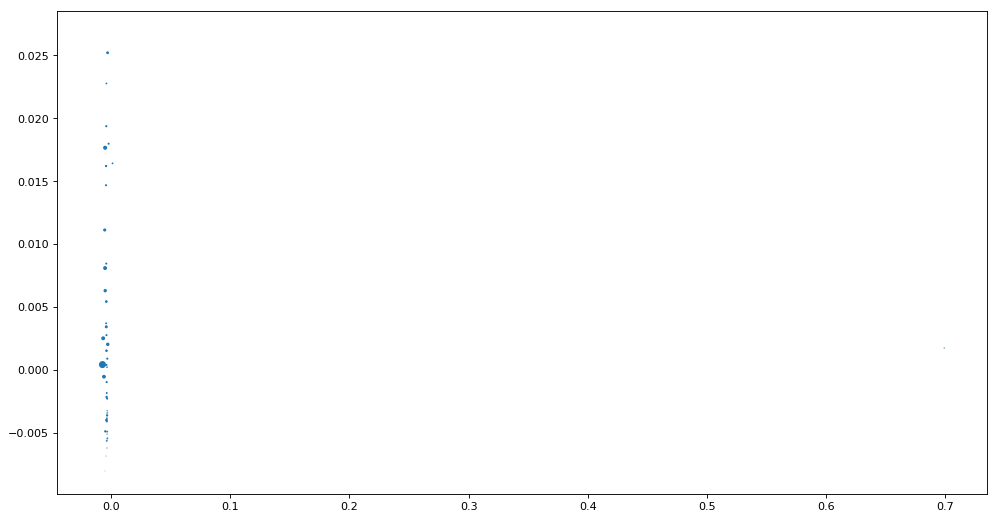

In [144]:
plot_prevs(prev_embed, annotate=False)

## bow -> tfidf -> fold-in-lsi

In [61]:
corpus = gensim.matutils.Dense2Corpus(df.values)

In [62]:
tfidf = gensim.models.TfidfModel(corpus=corpus)

INFO     [112] collecting document frequencies
INFO     [117] PROGRESS: processing document #0
INFO     [117] PROGRESS: processing document #10000
INFO     [130] calculating IDF weights for 15254 documents and 238 features (3645706 matrix non-zeros)


In [63]:
corpus_tfidf = tfidf[corpus]

In [64]:
lsi = gensim.models.LsiModel(corpus=corpus_tfidf, num_topics=4)

WARNING  [297] no word id mapping provided; initializing from corpus, assuming identity
INFO     [308] using serial LSI version on this node
INFO     [349] updating model with new documents
INFO     [374] preparing a new chunk of documents
DEBUG    [378] converting corpus to csc format
INFO     [636] using 100 extra samples and 2 power iterations
INFO     [644] 1st phase: constructing (0, 104) action matrix
INFO     [659] orthonormalizing (0, 104) action matrix
DEBUG    [558] computing QR of (0, 104) dense matrix


ValueError: failed to create intent(cache|hide)|optional array-- must have defined dimensions but got (0,)

In [ ]:
dense = gensim.matutils.corpus2csc(lsi[corpus_tfidf]).toarray()
plt.scatter(*dense)